In [1]:
import numpy as np
import gym
import os
import random
import time
from progressbar import ProgressBar
from time import sleep
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from matplotlib import image
from progressbar import ProgressBar

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras import optimizers
from keras import backend as K

from utils import pre_process_frame

# init env
env_name = 'Breakout-v0'
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.env.action_space.n

Using TensorFlow backend.


In [2]:
def create_network(action_size, alpha, initializer='glorot_uniform'):
    optimizer = optimizers.RMSprop(lr=alpha, clipvalue=0.5)
    
    net = Sequential([
        Conv2D(
            32,
            (8, 8),
            strides=(4,4),
            input_shape=(84, 84, 4),
            activation='relu',
            kernel_initializer=initializer,
            data_format="channels_last"
        ),
        Conv2D(
            64,
            (4,4),
            strides=(2,2),
            activation='relu',
            kernel_initializer=initializer
        ),
        Conv2D(
            64,
            (3,3),
            strides=(1,1),
            activation='relu',
            kernel_initializer=initializer
        ),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer=initializer),
        Dense(action_size, activation='linear', kernel_initializer=initializer)
    ])
    net.compile(loss='mse', optimizer=optimizer)
    return net

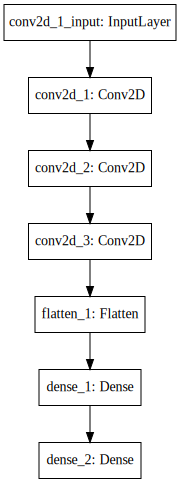

In [3]:
alpha = 0.00025
gamma=0.99
epochs=10000
action_update_interval = 4
q_update_interval = 16
qhat_update_interval = 500
sample_size=32 # how many samples do we take each time
min_replay_size = 500 # whhen does training start (replay mem size)
max_replay_size = 25000 # what is the max replay memory
chart_interval = 1000

# step increment at begining of loop
step = -1

# trainy boi
training_started = False
frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
prime_frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
action_memory = np.zeros((max_replay_size, 1), dtype='int')
reward_memory = np.zeros((max_replay_size, 1), dtype='float')
done_memory = np.zeros((max_replay_size, 1), dtype='bool')

replay_index = -1

# stats
training_rewards = []
rewards = []
mean_rewards = []
mean_training_rewards = []
epsilons = []
training_loss = []
training_step = []
training_score = []
test_score = []
last_episode = 0

# init networks
q_net = create_network(action_size, alpha)
q_hat_net = create_network(action_size, alpha, 'zeros')

pbar = ProgressBar()


SVG(model_to_dot(q_net).create(prog='dot', format='svg'))

  9% (999 of 10000) |##                   | Elapsed Time: 0:41:54 ETA:  7:25:18

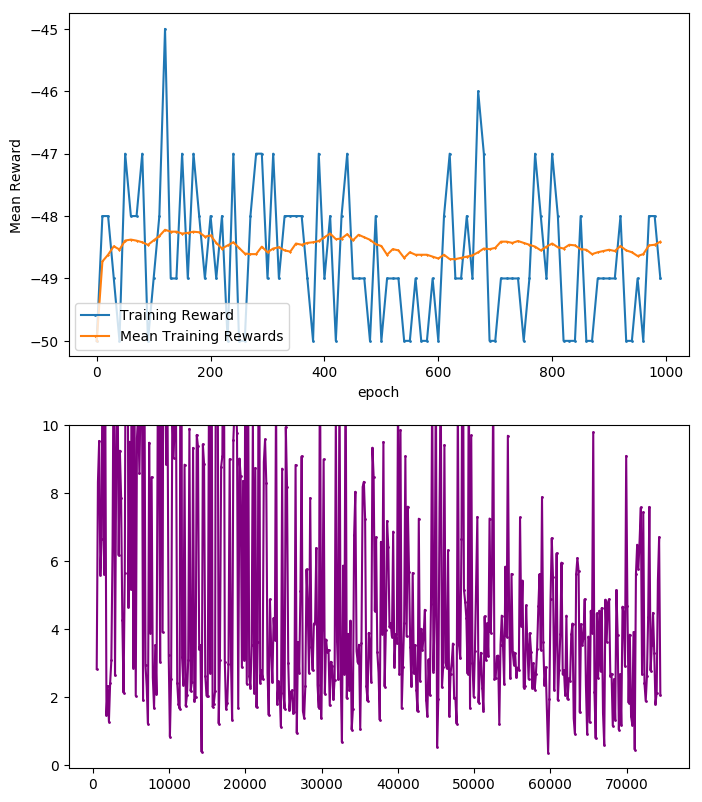

 19% (1999 of 10000) |###                 | Elapsed Time: 1:32:37 ETA:  6:41:41

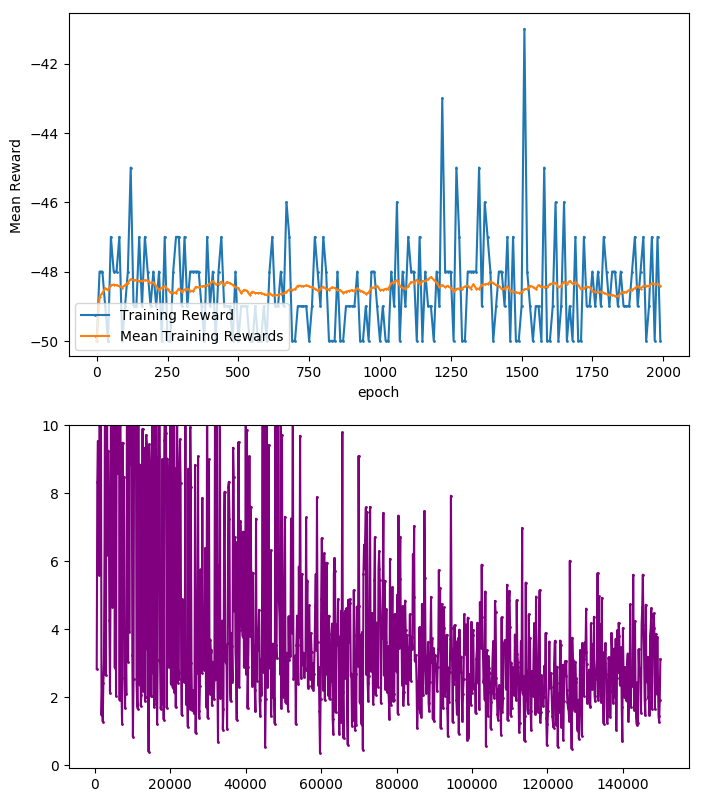

 29% (2999 of 10000) |#####               | Elapsed Time: 2:23:02 ETA:  5:46:22

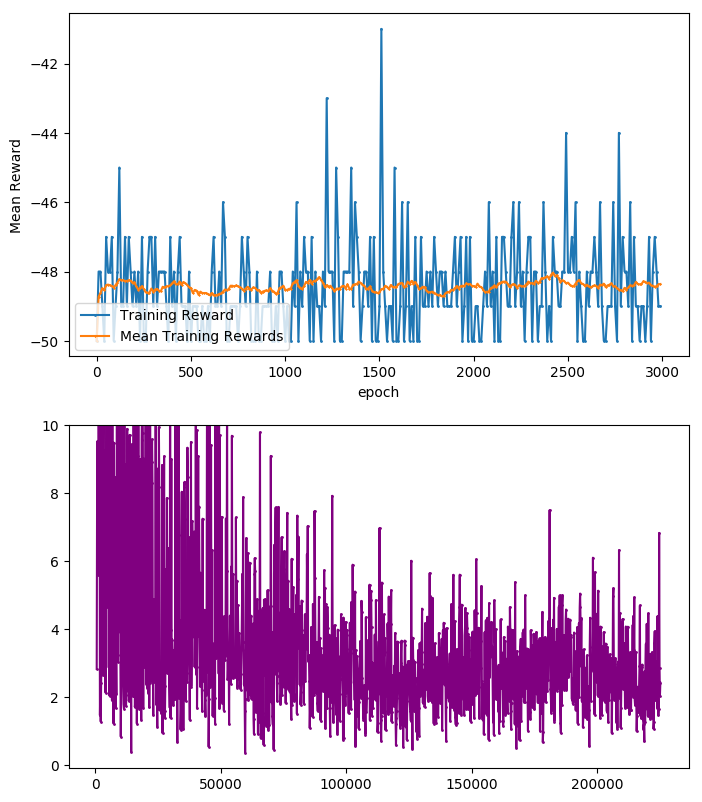

 39% (3999 of 10000) |#######             | Elapsed Time: 3:14:08 ETA:  5:11:50

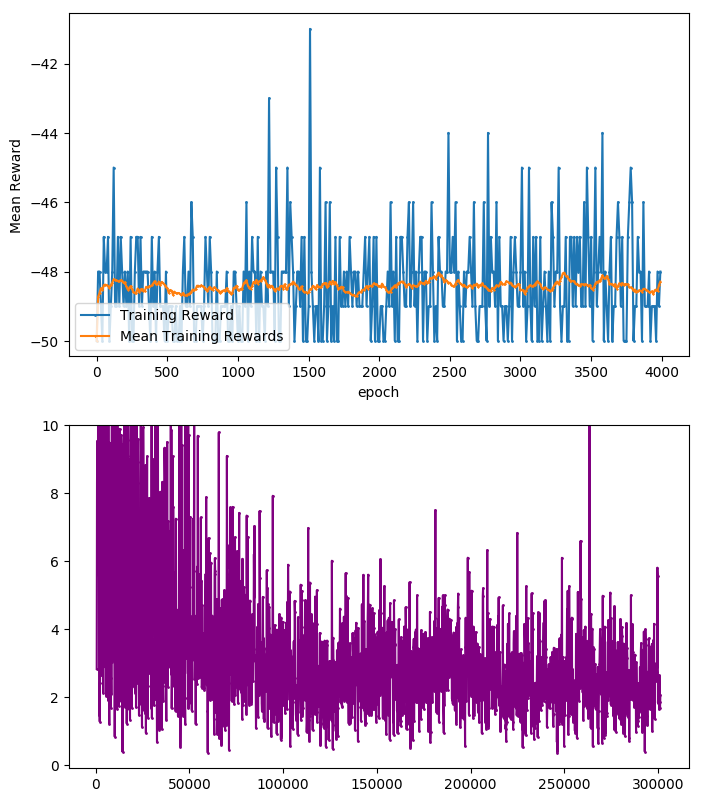

 49% (4999 of 10000) |#########           | Elapsed Time: 4:04:59 ETA:  4:12:55

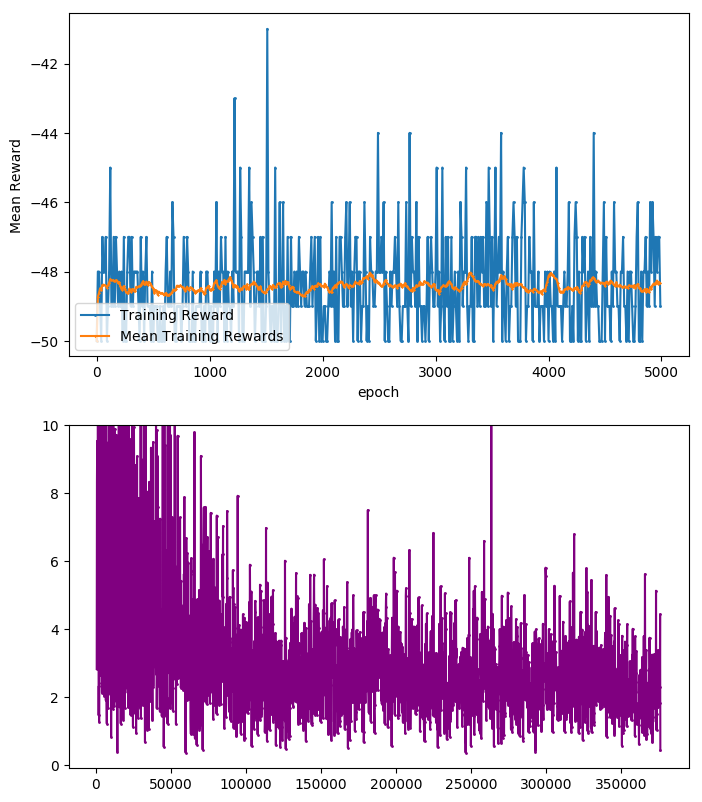

 59% (5999 of 10000) |###########         | Elapsed Time: 4:55:51 ETA:  3:42:05

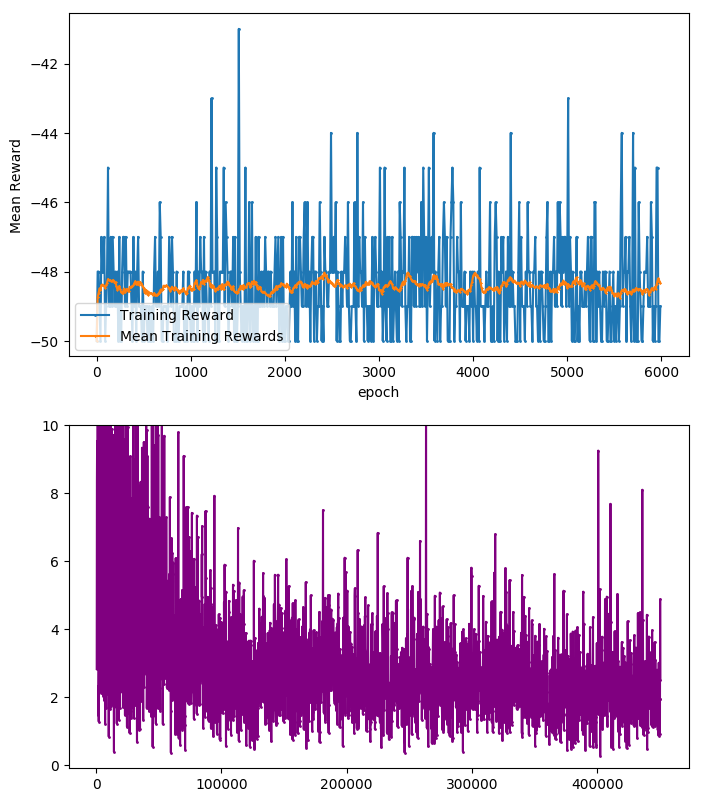

 69% (6999 of 10000) |#############       | Elapsed Time: 5:45:46 ETA:  2:23:33

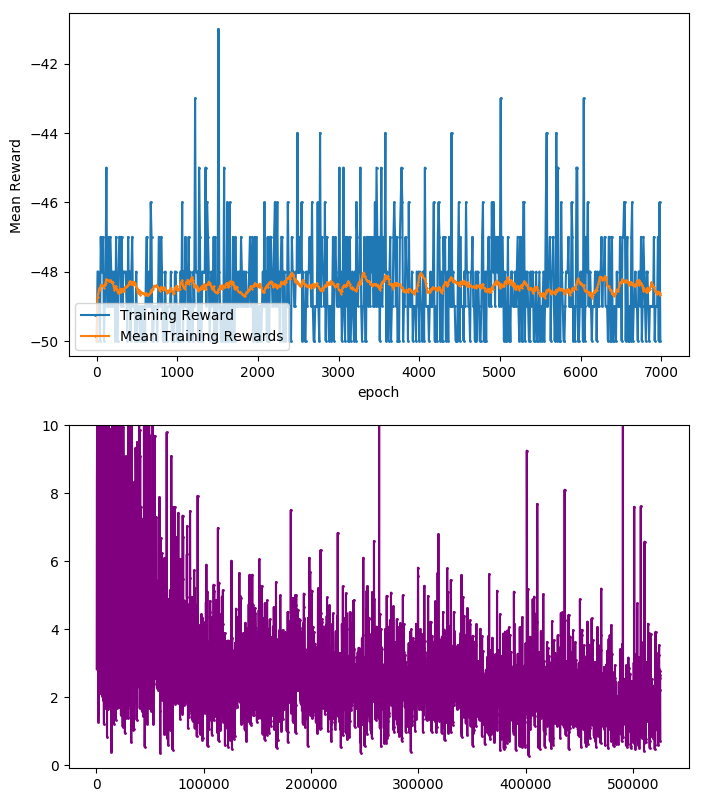

 79% (7999 of 10000) |###############     | Elapsed Time: 6:34:37 ETA:  1:34:27

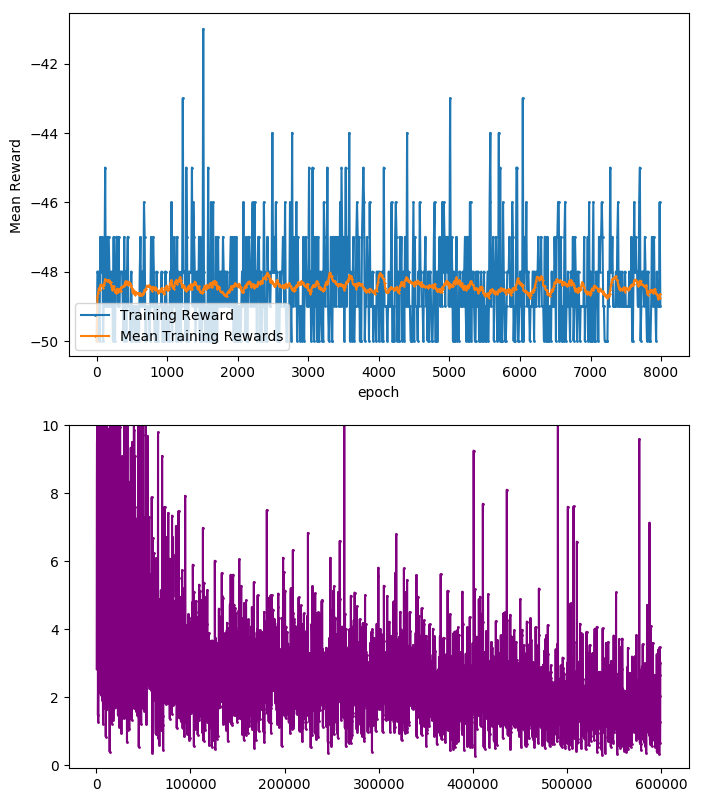

 89% (8999 of 10000) |#################   | Elapsed Time: 7:24:10 ETA:  0:48:43

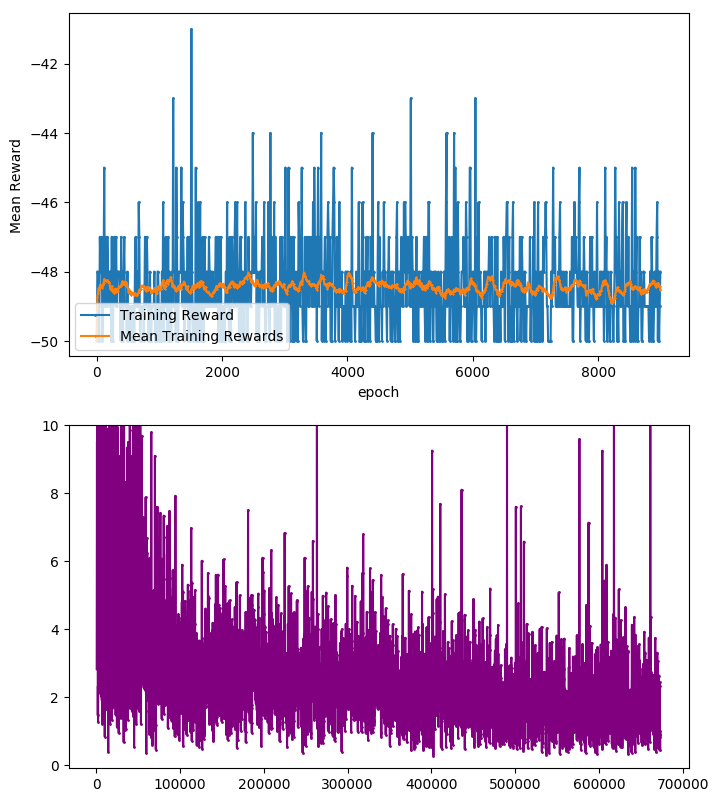

 99% (9999 of 10000) |################### | Elapsed Time: 8:13:50 ETA:  0:00:02

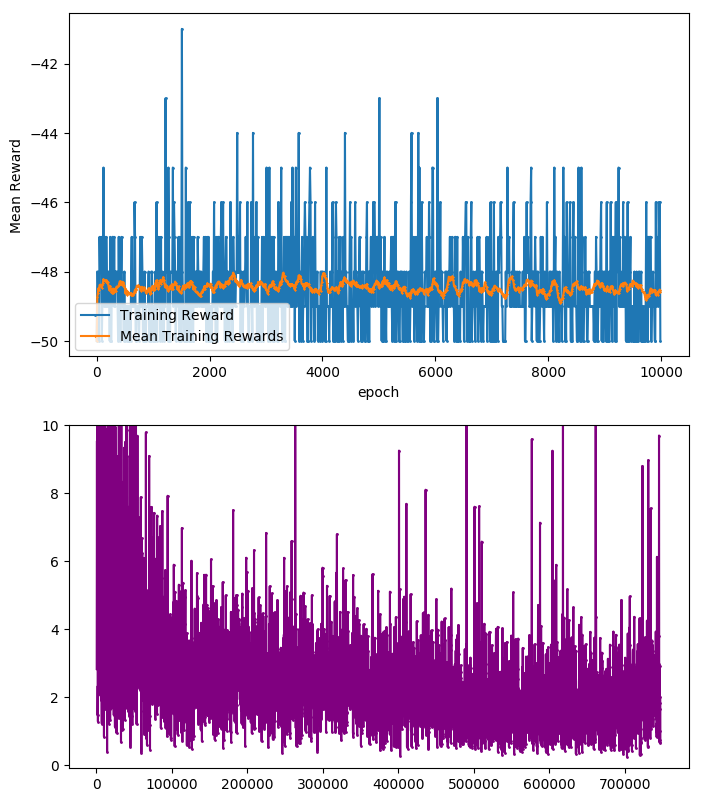

100% (10000 of 10000) |###################| Elapsed Time: 8:14:00 Time: 8:14:00


In [4]:

def time_usage(func):
    def wrapper(*args, **kwargs):
        beg_ts = time.time()
        retval = func(*args, **kwargs)
        end_ts = time.time()
        # print("elapsed time %s: %f" % (func.__name__, end_ts - beg_ts))
        return retval
    return wrapper

def run_episode(epsilon, render=True):
    # print("Start Episode: epsilon %s", epsilon)
    moves = 0
    beg_ts = time.time()
    done = False
    frame = env.reset()
    old_lives = -1
    prev_frame = np.zeros_like(frame) # the "prevvious" frame is nothing
    phi_frame = pre_process_frame(frame, prev_frame)

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            phi_shape = phi_frame.shape
            shaped_frame = phi_frame.reshape(1, phi_shape[0], phi_shape[1], phi_shape[2])
            action = np.argmax(q_net.predict(shaped_frame))

        reward = 0
        
        for i in range(action_update_interval):
            prime_frame, _reward, done, ale_lives = env.step(action)
            reward += _reward
            lives = ale_lives['ale.lives']
            
            if lives < old_lives:
                reward -= 10
            old_lives = lives
            
            done = done or lives == 0

        if render:
            env.render()
            
        phi_prime_frame = pre_process_frame(frame, prime_frame)
        
        yield phi_frame, action, reward, phi_prime_frame, done, lives

        phi_frame = phi_prime_frame
        prev_frame = frame
        frame = prime_frame
        moves += 1

    end_ts = time.time()
    # print("elapsed time run_episode: %s moves %fs" % (moves, end_ts - beg_ts))

weight_updates = 0

# @time_usage
def update_weights():
    # crop memory
    global frame_memory, action_memory, reward_memory, prime_frame_memory, done_memory, weight_updates, replay_index

    memory_sample = random.sample(
        range(0, min(replay_index, max_replay_size)),
        sample_size
    )

    _frame_batch = frame_memory[memory_sample]
    _prime_frame_batch = prime_frame_memory[memory_sample]
    _action_batch = action_memory[memory_sample]
    _reward_batch = reward_memory[memory_sample]
    _done_batch = done_memory[memory_sample]

    _predictions = q_net.predict(_frame_batch)
    _corrections = _predictions.copy()
    _prime_predictions = q_hat_net.predict(_prime_frame_batch)

    for i in range(0, sample_size):
        _done = _done_batch[i]
        _reward = _reward_batch[i]
        _action = _action_batch[i]

        _prime_prediction = _prime_predictions[i]
        if _done:
            _corrections[i, _action] = _reward_batch[i]
        else:
            _corrections[i, _action] = _reward + gamma * np.max(_prime_prediction)
    loss = q_net.train_on_batch(_frame_batch, _corrections)
    
    if weight_updates % qhat_update_interval == 0:
        # print("updating target")
        q_hat_net.set_weights(q_net.get_weights())
    weight_updates += 1
    return loss

step = -1
training_started = False

for episode in pbar(range(last_episode, epochs)):
    last_episode = episode
    
    if episode < epochs / 2:
        epsilon = 0.99
#     elif episode < epochs / 5:
#         epsilon = 0.75
#     elif episode < epochs / 2:
#         epsilon = 0.50
#     else:
#         epsilon = 0.0

    training_score = 0

    # for every action in the episode
    for (
        frame,
        action,
        reward,
        prime_frame,
        done,
        lives
    ) in run_episode(.99, render=True):
        step += 1
        #
        replay_index += 1
        replay_array_index = replay_index % max_replay_size
        frame_memory[replay_array_index] = frame
        prime_frame_memory[replay_array_index] = prime_frame
        action_memory[replay_array_index] = action
        reward_memory[replay_array_index] = reward
        done_memory[replay_array_index] = done

        training_score += reward

        # if time do the training
        if step % q_update_interval == 0 and min_replay_size < replay_index:
            if not training_started:
                training_started = True
                # print("Training Started: ", step)
            loss = update_weights()
            training_loss.append(loss)
            training_step.append(step)


# #     test the net
#     test_score = 0

#     for (
#         prev_frame,
#         action,
#         reward,
#         frame,
#         done,
#         lives
#     ) in run_episode(0.01, pool_actions=False, render=True):
#         test_score += test_score

    # print("Record metrics")
    training_rewards.append(training_score)
#     rewards.append(test_score)
#     mean_rewards.append(np.mean(rewards[-100:]))
    mean_training_rewards.append(np.mean(training_rewards[-100:]))
    epsilons.append(epsilon)

    # display progress
    if (episode + 1) % chart_interval == 0:
        index_step = 10
        episodes_num = np.arange(0, len(mean_training_rewards))[0::index_step]
        _mean_training_rewards = mean_training_rewards[0::index_step]
        #         _mean_rewards = mean_rewards[0::index_step]
        #         _rewards = rewards[0::index_step]
        _training_rewards = training_rewards[0::index_step]
        _epsilons = epsilons[0::index_step]
        episode_index = len(mean_training_rewards)


        fig = plt.figure(figsize=(8, 10), dpi=100)
        plt.subplot(211)
        plt.plot(episodes_num, _training_rewards, marker='o', markersize=1, label='Training Reward')
        #         par1.plot(episodes_num, _rewards, marker='o', markersize=5, label='Test Reward')
        plt.plot(episodes_num, _mean_training_rewards, marker='x', markersize=1, label='Mean Training Rewards')
        #         par1.plot(episodes_num, _mean_rewards, marker='o', markersize=5, label='Mean Test Reward')
        plt.legend(loc='lower left')
        plt.xlabel('epoch')
        plt.ylabel('Mean Reward')

        plt.subplot(212)
        plt.plot(training_step[0::index_step], training_loss[0::index_step], marker='o', markersize=1, label='Training Loss', color='purple')
        plt.ylim(-0.1, 10)

        plt.pause(0.01)

        # save after charting
        model_file = '%s-%s-%s-pool-actions.weights' % (env_name, alpha, episode)
        q_net.save_weights(model_file)


       

In [ ]:
model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
net.save_weights(model_file)
print(model_file)